# Testing Naive KNN Model

We want to get as much from our model as possible. The model is parametrised so we want to find best parameters for a given problem.

## Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import csv
import json
from sklearn.metrics import mean_squared_error
from data_helper import get_data, data_to_matrix
from naive_model import KNNRecommender

## Data

In [21]:
# gets the data
data = get_data()

In [22]:
# makes data a matrix
user_anime_matrix = data_to_matrix(data)

Now let's select some users with enough raitings and hide part of those ritings. Later on we will predict predicted raitings with the hidden ones.

In [23]:
min_ratings = 25  # minimal number of ratings for user to be used for testing predictions
user_ratings_count = np.count_nonzero(user_anime_matrix > 0, axis=1)
users_with_many_ratings = np.where(user_ratings_count > min_ratings)[0]

# we will test for small number of users, cause algorithm is sloooooow
users_testing = np.random.choice(users_with_many_ratings, 50, replace=False)

user_dict = dict()
test_data = []
train_matrix = user_anime_matrix.copy()

for user in users_testing:
    # find rated anime
    rated_anime = np.where(user_anime_matrix[user] > 0)[0]
    if len(rated_anime) > 1:
        # randomly chose some of them
        test_anime_idx = np.random.choice(
            rated_anime, len(rated_anime) // 8 , replace=False
        )

        user_dict[str(user)] = test_anime_idx.tolist()

        # remember user
        test_data.append(user)

        # delete from training matrix
        train_matrix[user, test_anime_idx] = 0

test_data = np.array(test_data)
true_raitings = user_anime_matrix[test_data]

## Testing

### Feed model with data

In [24]:
model = KNNRecommender()

print(model.fit(train_matrix))

Selected 437 users for users_base.
Succesful fit


### MSE for given parameters

In [25]:
def MSE_for_parameters(k, weight_factor, penalty_factor):
    predictions = model.predict(
        test_data, k=k, weight_factor=weight_factor, penalty_factor=penalty_factor
    )

    total_squared_error = 0  # initialize total squared error
    total_count = 0  # initialize total count of test ratings

    for idx, user in enumerate(test_data):
        if str(user) in user_dict:
            test_anime_indices = np.array(
                user_dict[str(user)]
            )  # get test anime indices
            user_true_ratings = true_raitings[idx, test_anime_indices]  # true ratings
            user_predicted_ratings = predictions[
                idx, test_anime_indices
            ]  # predicted ratings

            # calculate squared errors for test anime
            user_errors = (user_true_ratings - user_predicted_ratings) ** 2
            total_squared_error += np.sum(user_errors)  # add to total MSE
            total_count += len(user_errors)  # count the number of test ratings

    # return Mean Squared Error (divide by total count)
    return total_squared_error / total_count if total_count > 0 else float("inf")

### Test parameters

In [ ]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#ks = [8, 9, 10, 11]
weights = [1, 30, 80, 120, 140, 145, 150, 180]
# weights = [145]
# penaltys = [0.1, 0.2, 0.3, 0.6, 0.7, 0.8, 0.9, 1]
penaltys = [0.4, 0.5]

output_file = "MSE_results_2.csv"

headers = ["k", "weight_factor", "penalty_factor", "MSE"]

with open("dict_2.json", "w") as file:
    json.dump(user_dict, file, indent=4)

with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)  
    for k, w, p in itertools.product(ks, weights, penaltys):
        try:
            mse = MSE_for_parameters(k, w, p)
            writer.writerow([k, w, p, mse])
            print(f"Done for k={k}, weight={w}, penalty={p}: MSE={mse:.4f}")
        except Exception as e:
            print(f"Error for k={k}, weight={w}, penalty={p}: {e}")

Done for k=8, weight=1, penalty=0.1: MSE=1.9497
Done for k=8, weight=1, penalty=0.2: MSE=1.9076
Done for k=8, weight=1, penalty=0.3: MSE=1.8845
Done for k=8, weight=1, penalty=0.6: MSE=1.9337
Done for k=8, weight=1, penalty=0.7: MSE=1.9528
Done for k=8, weight=1, penalty=0.8: MSE=1.9379
Done for k=8, weight=1, penalty=0.9: MSE=1.9200
Done for k=8, weight=1, penalty=1: MSE=1.9315
Done for k=8, weight=30, penalty=0.1: MSE=1.9477
Done for k=8, weight=30, penalty=0.2: MSE=1.9054
Done for k=8, weight=30, penalty=0.3: MSE=1.8826
Done for k=8, weight=30, penalty=0.6: MSE=1.9309
Done for k=8, weight=30, penalty=0.7: MSE=1.9496
Done for k=8, weight=30, penalty=0.8: MSE=1.9348
Done for k=8, weight=30, penalty=0.9: MSE=1.9175
Done for k=8, weight=30, penalty=1: MSE=1.9288
Done for k=8, weight=80, penalty=0.1: MSE=1.9452
Done for k=8, weight=80, penalty=0.2: MSE=1.9024
Done for k=8, weight=80, penalty=0.3: MSE=1.8800
Done for k=8, weight=80, penalty=0.6: MSE=1.9267
Done for k=8, weight=80, penalty

Code above takes some time to stop running (hours on my computer) so I've decided to save results and load them again.

### Visualize results

Load the CSV file into a DataFrame.

In [34]:
data = pd.read_csv("MSE_results_1.csv")

with open("dict.json", "r") as file:
    user_dict = json.load(file)

Let's look at parameters giving best results.

In [35]:
best_row = data.loc[data["MSE"].idxmin()]
best_params = best_row[["k", "weight_factor", "penalty_factor"]]
best_MSE = best_row["MSE"]

print(
    f"Best parameters: k={best_params['k']}, weight_factor={best_params['weight_factor']}, "
    f"penalty_factor={best_params['penalty_factor']}, MSE={best_MSE:.4f}"
)

Best parameters: k=10.0, weight_factor=180.0, penalty_factor=0.3, MSE=1.8646


Now let's plot our results, it's always nice to see a plot.

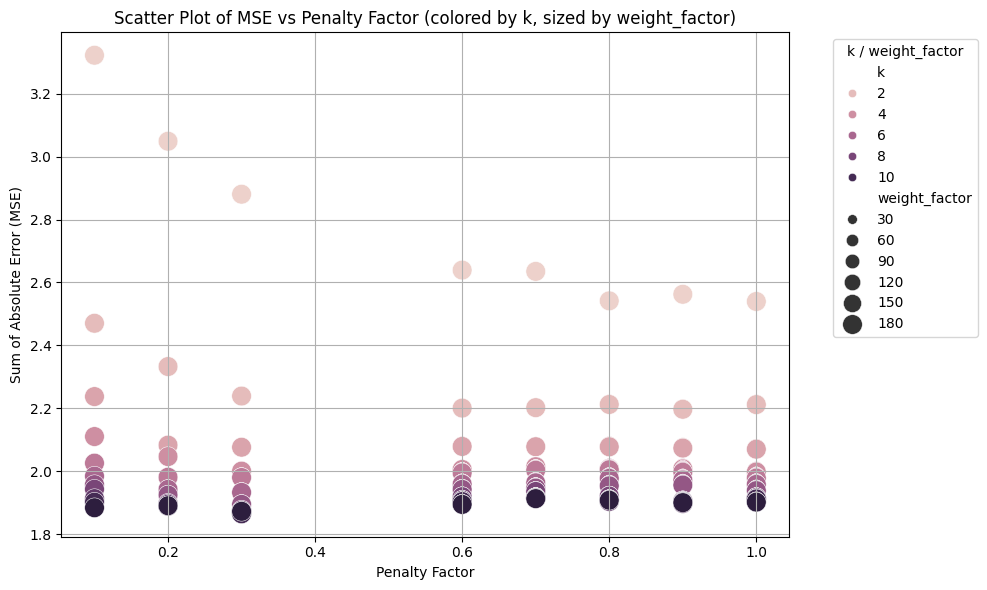

In [36]:
# scatter plot of all MSE values to find patterns
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="penalty_factor",
    y="MSE",
    hue="k",
    size="weight_factor",
    sizes=(20, 200),
)

# add annotations
plt.title(
    "Scatter Plot of MSE vs Penalty Factor (colored by k, sized by weight_factor)"
)
plt.xlabel("Penalty Factor")
plt.ylabel("Sum of Absolute Error (MSE)")
plt.legend(title="k / weight_factor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig("MSE_scatter_plot.png")  # save the scatter plot
plt.show()

## Is our MSE low enough?

At this point, I would like to stop for a moment and just ask a question if anything that we have done has any meaning.  We lowered a bit our MSE but we don't feel how it affects our results. Is MSE about 40 even acceptable for the subset of predicted ratings?

Let's simply make once again predict with the best parameters and look how close we were.

In [37]:
# calculate prediction errors for the best parameters
k_best, weight_factor_best, penalty_factor_best = (
    best_params["k"],
    best_params["weight_factor"],
    best_params["penalty_factor"],
)

# get predictions
predictions = model.predict(
    test_data,
    k=int(k_best),
    weight_factor=weight_factor_best,
    penalty_factor=penalty_factor_best,
)

# initialize list for storing errors
filtered_errors = []

# iterate over test users and filter for test anime
for idx, user in enumerate(test_data):
    if str(user) in user_dict:
        test_anime_indices = np.array(user_dict[str(user)])  # indices of anime for this user in test
        user_true_ratings = true_raitings[idx, test_anime_indices]  # true ratings
        user_predicted_ratings = predictions[idx, test_anime_indices]  # predictions

        # compute absolute errors for these indices
        user_errors = np.abs(user_true_ratings - user_predicted_ratings)
        filtered_errors.extend(user_errors)

# convert to numpy array
filtered_errors = np.array(filtered_errors)

# calculate average absolute error
average_error = np.mean(filtered_errors)
print(f"Average absolute error: {average_error:.4f}")

Average absolute error: 1.0513


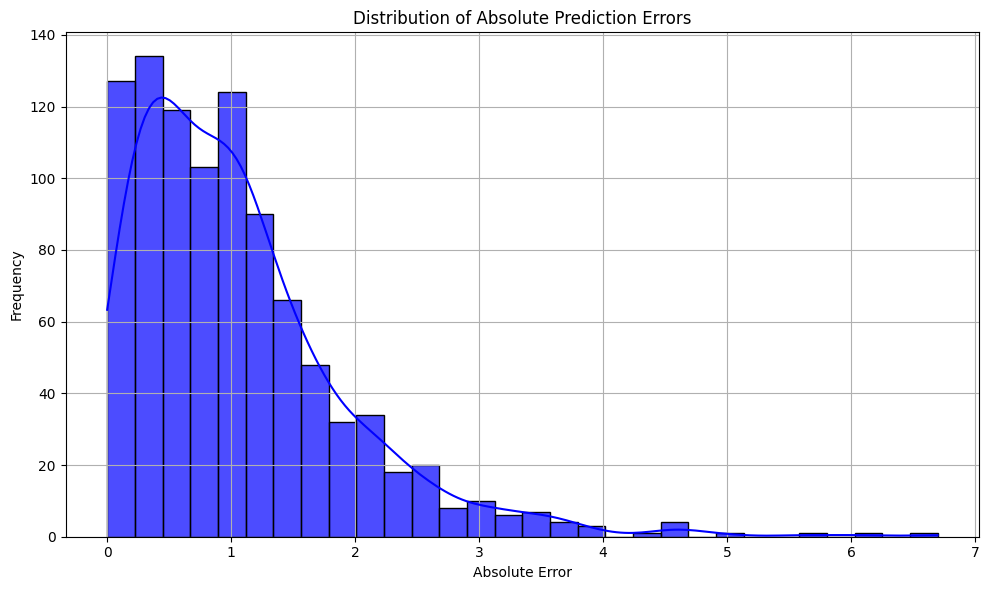

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_errors, bins=30, kde=True, color="blue", alpha=0.7)

# add annotations
plt.title("Distribution of Absolute Prediction Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("filtered_error_distribution.png")  # save the plot
plt.show()

Keep in mind that raiting given by user is always an integer. Some of our errors after parsing to integer wouldn't be visible.

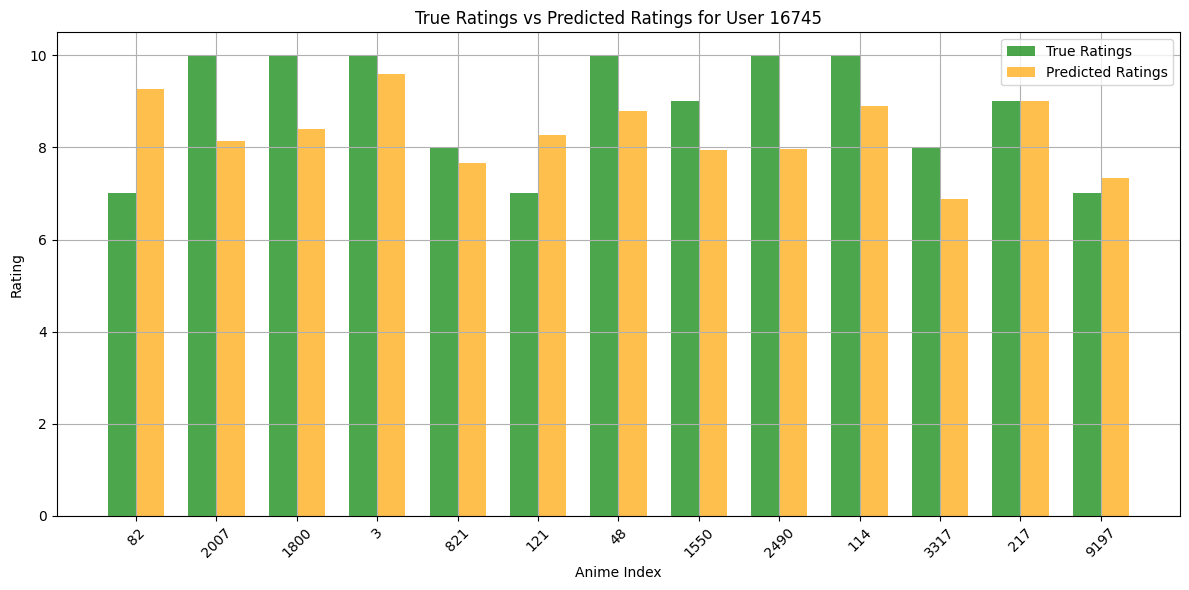

In [46]:
# randomly pick one user to compare true ratings vs predictions
random_user_idx = np.random.choice(
    test_data.shape[0]
)  # wybierz losowego użytkownika z test_data
random_user = test_data[random_user_idx]  # faktyczny indeks użytkownika

# retrieve the indices of anime for this user that were in the test set
if str(random_user) in user_dict:
    test_anime_indices = np.array(user_dict[str(random_user)])  # pobierz oceniane anime

    # extract true ratings and predictions for these anime
    true_user_ratings = true_raitings[random_user_idx, test_anime_indices]
    predicted_user_ratings = predictions[random_user_idx, test_anime_indices]

    # create a bar plot comparing true ratings and predictions for the user
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    indices = np.arange(len(test_anime_indices))

    plt.bar(
        indices,
        true_user_ratings,
        bar_width,
        label="True Ratings",
        alpha=0.7,
        color="green",
    )
    plt.bar(
        indices + bar_width,
        predicted_user_ratings,
        bar_width,
        label="Predicted Ratings",
        alpha=0.7,
        color="orange",
    )

    # add annotations
    plt.title(f"True Ratings vs Predicted Ratings for User {random_user}")
    plt.xlabel("Anime Index")
    plt.ylabel("Rating")
    plt.xticks(indices + bar_width / 2, test_anime_indices, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"user_{random_user}_rating_comparison.png")  # save the plot
    plt.show()

else:
    print(f"User {random_user} is not in the test dictionary.")